In [25]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, roc_auc_score, r2_score, mean_squared_error
import operator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = MinMaxScaler()


In [26]:
df = pd.read_csv('../Competition/train.csv')
df_test = pd.read_csv('../Competition/test.csv')
target_col = 'Exited'

df.drop(columns=['id', 'CustomerId', 'Surname'], inplace=True)
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['Exited']), df['Exited'], test_size=0.2, random_state=12)

numeric_cols = X_train.select_dtypes(include='number').columns
categorical_cols = X_train.select_dtypes(include='object').columns

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, model_pipeline.predict_proba(inputs)[:, 1])
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds



C:\Users\Dasha\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\Dasha\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
C:\Users\Dasha\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penal

Best parameters: {'classifier__C': 0.09, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best cross-validation score: 0.9284792576101025
Area under ROC score on train poly 4 dataset: 0.93%


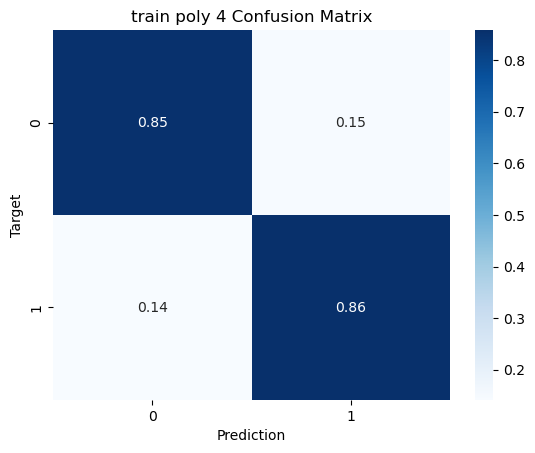

Area under ROC score on val poly 4 dataset: 0.93%


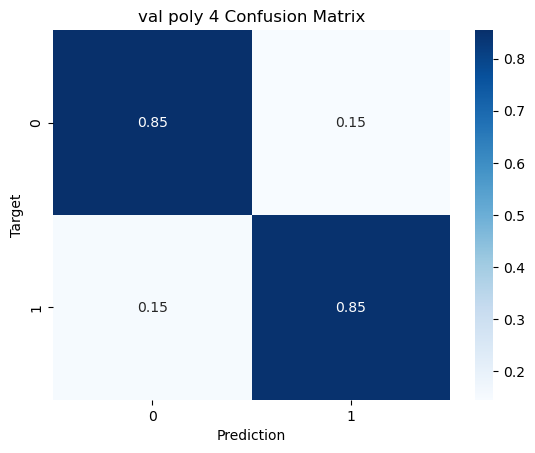

In [48]:
numeric_transformer_poly_4 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])


preprocessor_poly_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

model_pipeline_poly_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly_4),
    ('classifier', LogisticRegression(max_iter=2000, random_state=12, class_weight='balanced'))
])
params = {
    'classifier__C': [0.01,0.09,0.1,1,10],
    'classifier__penalty': ['l1','l2'],
    'classifier__solver': ['liblinear', 'saga']
}
grid = GridSearchCV(model_pipeline_poly_4, param_grid=params, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

train_preds = predict_and_plot(best_model, X_train, y_train, name='train poly 4')
val_preds = predict_and_plot(best_model, X_val, y_val, name='val poly 4')

test_probs = best_model.predict_proba(df_test)[:, 1]

submission = pd.DataFrame({
    'id': df_test['id'],   
    'Exited': test_probs.round(4)
})

submission.to_csv('submission.csv', index=False)
